# 1. Imports

In [1]:
from os import walk
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import recall_score, precision_score, f1_score

# Natural Language Toolkit
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image

# 2.  Constants

In [2]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'
SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'

TOKEN_SPAM_PROB_FILE = 'SpamData/03_Testing/prob-spam.txt'
TOKEN_HAM_PROB_FILE = 'SpamData/03_Testing/prob-nonspam.txt'
TOKEN_ALL_PROB_FILE = 'SpamData/03_Testing/prob-all-tokens.txt'

THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'


# 3. Data Pre Processing

## 3.1 Sample Email

In [3]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
for line in stream:
    print(line)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002

Return-Path: <exmh-workers-admin@spamassassin.taint.org>

Delivered-To: zzzz@localhost.netnoteinc.com

Received: from localhost (localhost [127.0.0.1])

	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36

	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)

Received: from phobos [127.0.0.1]

	by localhost with IMAP (fetchmail-5.9.0)

	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)

Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by

    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for

    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100

Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by

    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002

    07:35:02 -0400 (EDT)

Delivered-To: exmh-workers@listman.spamassassin.taint.org

Received: f

## 3.2 Functions for extracting email body 

In [4]:
def email_body_generator(path):
    for root, dirnames, filenames in walk(path):
        for file_name in filenames: 
            filepath = join(root,file_name)
            stream = open(filepath, encoding='latin-1')
            # message = stream.read()
            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()
            email_body = '\n'.join(lines)
            yield file_name, email_body

In [5]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
    
    return pd.DataFrame(rows, index=row_names)

## 3.3 Creating DataFrame containing Spam and NonSpam Emails

### 3.3.1 Spam Emails

In [6]:
spam_emails = df_from_directory(SPAM_1_PATH,SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH,SPAM_CAT))
print(spam_emails.shape)
spam_emails.head()

(1898, 2)


,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


### 3.3.2 Non Spam Emails

In [7]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH,HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH,HAM_CAT))
print(ham_emails.shape)
ham_emails.head()

(3901, 2)


,MESSAGE,CATEGORY
00001.7c53336b37003a9286aba55d2945844c,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
00002.9c4069e25e1ef370c078db7ee85ff9ac,"Martin A posted:\n\nTassos Papadopoulos, the G...",0
00003.860e3c3cee1b42ead714c5c874fe25f7,Man Threatens Explosion In Moscow \n\n\n\nThur...,0
00004.864220c5b6930b209cc287c361c99af1,Klez: The Virus That Won't Die\n\n \n\nAlready...,0
00005.bf27cdeaf0b8c4647ecd61b1d09da613,"> in adding cream to spaghetti carbonara, whi...",0


### 3.3.3 Merge Spam and Non Spam Emails

In [8]:
data = pd.concat([spam_emails,ham_emails])
print(data.shape)
data.head()

(5799, 2)


,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


## 3.4 Data Cleaning

### 3.4.1 Check for Empty Or Null Messages

In [9]:
# Null messages
print(data['MESSAGE'].isnull().values.any())

False


In [10]:
# Empty Messages
print(data.loc[data.MESSAGE==""])
print(data[data.MESSAGE.str.len()==0].index)
data.drop(['cmds'], inplace=True) # Removing empty messages
print(data.shape)

     MESSAGE  CATEGORY
cmds                 1
cmds                 1
cmds                 0
Index(['cmds', 'cmds', 'cmds'], dtype='object')
(5796, 2)


### 3.4.2 Add Document IDs to data and set as index

In [11]:
data['DOC_ID'] = range(0,len(data.index))
data['FILE_NAME'] = data.index
data = data.set_index('DOC_ID')
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


### 3.4.3 Save the DataFrame as JSON file

In [12]:
data.to_json(DATA_JSON_FILE)

## 3.5 Data Cleaning using Natural Language Processing

### 3.5.1 Downloading NLTK Resources - Tokenizer and Stop Words

In [13]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\Gagan
[nltk_data]     Arora\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Gagan
[nltk_data]     Arora\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 3.5.2 Cleaning email body - <h5>Tokenizing, stripping html tags, removing punctuations, removing stop words and stemming</h5>

In [14]:
def clean_message(message, stemmer=PorterStemmer(),
                  stop_words=set(stopwords.words('english'))):
    """
    
    """    
    
    # Remove HTML Tags
    soup = BeautifulSoup(message,'html.parser')
    cleaned_text = soup.get_text()
    
    # Converts to lower case and splits up the words
    words = word_tokenize(cleaned_text.lower())
    filtered_words = []
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            stemmed_word = stemmer.stem(word)
            filtered_words.append(stemmed_word)
    return filtered_words

In [15]:
nested_list = data.MESSAGE.apply(clean_message)

C:\Users\Gagan Arora\.conda\envs\Custom\lib\site-packages\bs4\__init__.py:398: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  markup


In [16]:
nested_list.head()

DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
Name: MESSAGE, dtype: object

### 3.5.3 Separating Spam and Nonspam emails nested list

In [17]:
doc_ids_spam = data[data.CATEGORY==1].index
doc_ids_ham = data[data.CATEGORY==0].index
nested_list_spam = nested_list.loc[doc_ids_spam]
nested_list_ham = nested_list.loc[doc_ids_ham]

# 4. Data Visualizations

## 4.1 Generating Spam and Nonspam WordCloud

In [18]:
# function without stemmer
def clean_message_without_stemmer(message, stop_words=set(stopwords.words('english'))):

    # Remove HTML Tags
    soup = BeautifulSoup(message,'html.parser')
    cleaned_text = soup.get_text()
    
    # Converts to lower case and splits up the words
    words = word_tokenize(cleaned_text.lower())
    filtered_words = []
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():            
            filtered_words.append(word)
    return filtered_words

In [19]:
nested_list_2 = data.MESSAGE.apply(clean_message_without_stemmer)

In [20]:
doc_ids_spam = data[data.CATEGORY==1].index
doc_ids_ham = data[data.CATEGORY==0].index
nested_list_spam = nested_list.loc[doc_ids_spam]
nested_list_ham = nested_list.loc[doc_ids_ham]
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]

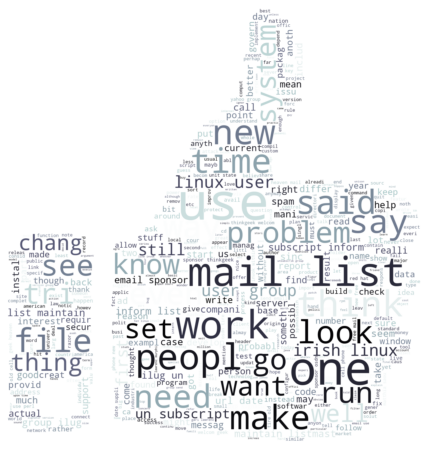

In [21]:
thumbs_up_icon = Image.open(THUMBS_UP_FILE)
# blank canvas
thumbs_up_image_mask = Image.new(mode='RGB', size=thumbs_up_icon.size, color=(255,255,255))
thumbs_up_image_mask.paste(thumbs_up_icon, box=thumbs_up_icon)
rgb_array = np.array(thumbs_up_image_mask) #converts the image object to an array

ham_str = ' '.join(flat_list_ham)
word_cloud_2 = WordCloud(mask=rgb_array, background_color='white',max_words=500, colormap='bone')
word_cloud_2.generate(ham_str)

plt.figure(figsize=(16,8))
plt.imshow(word_cloud_2, interpolation='bilinear')
plt.axis('off')
plt.show()

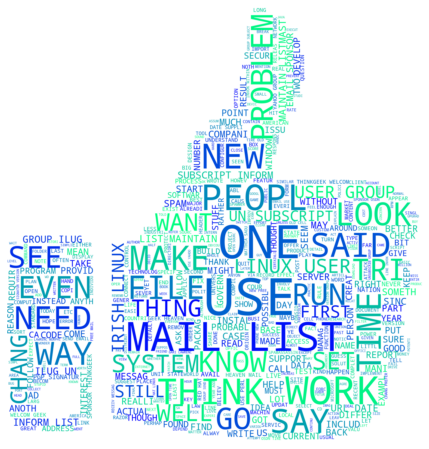

In [22]:
thumbs_up_icon = Image.open(THUMBS_UP_FILE)
# blank canvas
thumbs_up_image_mask = Image.new(mode='RGB', size=thumbs_up_icon.size, color=(255,255,255))
thumbs_up_image_mask.paste(thumbs_up_icon, box=thumbs_up_icon)
rgb_array = np.array(thumbs_up_image_mask) #converts the image object to an array

ham_str = ' '.join(flat_list_ham)
word_cloud_2 = WordCloud(mask=rgb_array, background_color='white',max_words=500, colormap='winter')
word_cloud_2.generate(ham_str.upper())

plt.figure(figsize=(16,8))
plt.imshow(word_cloud_2, interpolation='bilinear')
plt.axis('off')
plt.show()

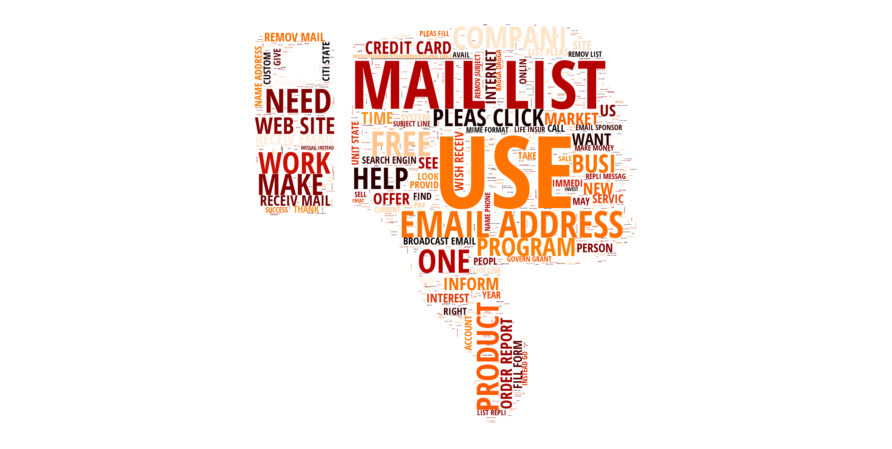

In [23]:
thumbs_down_icon = Image.open(THUMBS_DOWN_FILE)
# blank canvas
thumbs_down_image_mask = Image.new(mode='RGB', size=thumbs_down_icon.size, color=(255,255,255))
thumbs_down_image_mask.paste(thumbs_down_icon, box=thumbs_down_icon)
rgb_array = np.array(thumbs_down_image_mask) #converts the image object to an array

spam_str = ' '.join(flat_list_spam)
word_cloud_2 = WordCloud(mask=rgb_array, background_color='white',max_font_size=300,
                         max_words=800, colormap='gist_heat',font_path=CUSTOM_FONT_FILE)
word_cloud_2.generate(spam_str.upper())

plt.figure(figsize=(16,8))
plt.imshow(word_cloud_2, interpolation='bilinear')
plt.axis('off')
plt.show()

## 4.2 Pie Chart

In [24]:
amount_of_spam = data['CATEGORY'].value_counts()[1] # Number of Spam Emails
amount_of_ham = data['CATEGORY'].value_counts()[0] # Number of NonSpam Emails

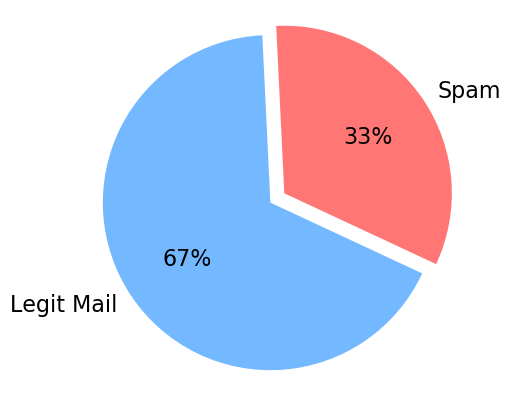

In [25]:
labels = ['Spam', 'Legit Mail']
# sizes = [(data['CATEGORY']==SPAM_CAT).sum(), (data['CATEGORY']==HAM_CAT).sum()]
sizes = [amount_of_spam, amount_of_ham]
# colors = ['gold', 'yellowgreen']
custom_colors = ['#ff7675','#74b9ff']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.figure(figsize=(5,5), dpi=100)
plt.pie(sizes,labels=labels,explode=explode, textprops={'fontsize':16},
        colors=custom_colors, autopct='%1.0f%%', startangle=-25)

plt.axis('equal')
plt.show()

## 4.3 Donut Chart

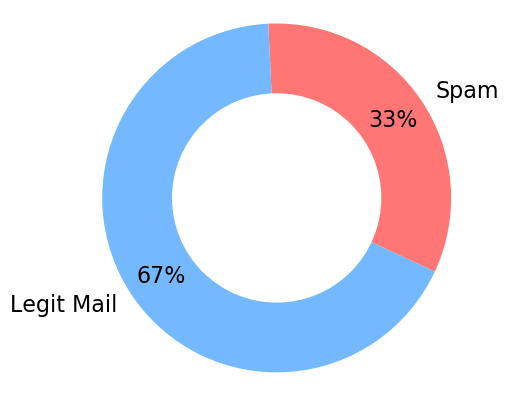

In [26]:
# Donut chart
labels = ['Spam', 'Legit Mail']
# sizes = [(data['CATEGORY']==SPAM_CAT).sum(), (data['CATEGORY']==HAM_CAT).sum()]
sizes = [amount_of_spam, amount_of_ham]
# colors = ['gold', 'yellowgreen']
custom_colors = ['#ff7675','#74b9ff']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.figure(figsize=(5,5), dpi=100)
plt.pie(sizes,labels=labels,textprops={'fontsize':16},
        colors=custom_colors, autopct='%1.0f%%', pctdistance=0.8, startangle=-25)

centre_circle = plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.axis('equal')
plt.show()

# 5. Generate Vocabulary and Dictionary

In [27]:
stemmed_nested_list = data.MESSAGE.apply(clean_message)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]
print(f'Shape of Nested List: {stemmed_nested_list.shape}')

Shape of Nested List: (5796,)


In [28]:
len(flat_stemmed_list)

757852

In [29]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Number of unique words', unique_words.shape[0])
frequent_words = unique_words[:VOCAB_SIZE]
frequent_words[:10]

Number of unique words 27218


http     10648
use       5015
list      4849
email     4366
get       4187
mail      3983
one       3905
free      3171
time      3041
work      2880
dtype: int64

In [30]:
word_ids = list(range(0,VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values,'FREQ': frequent_words.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD,FREQ
WORD_ID,,
0,http,10648
1,use,5015
2,list,4849
3,email,4366
4,get,4187


## 5.1 Lengths of Email

In [31]:
clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list]
max_loc = np.argmax(clean_email_lengths) # location of email with max length
data.at[max_loc,'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

# 6. Generate Features and Sparse Matrix

In [32]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


## 6.1 Splitting into Training and Test Dataset

In [33]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df,data['CATEGORY'],test_size=0.30,random_state=42)

In [34]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,ye,inde,agent,directori,verita,cd,unix,subdirectori,file,call,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,harddissssk,like,alreadi,mount,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,origin,messag,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inlin,folk,sever,major,internet,outag,morn,across,major,provid,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicl,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


## 6.2 Create a Sparse Matrix of training data

In [35]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe.
    
    df: A dataframe with words in the columns with a document id as an index (X_train or X_test)
    indexed_words: index of words ordered by word_id
    labels: category as a series (y_train or y_test)
    """
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            word = df.iat[i,j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {
                    'LABEL': category,
                    'DOC_ID': doc_id,
                    'OCCURENCE': 1,
                    'WORD_ID': word_id
                }
                dict_list.append(item)
    
    
    return pd.DataFrame(dict_list)

In [36]:
word_index = pd.Index(vocab['VOCAB_WORD'])
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)
sparse_train_df.head()

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4844,1,265
1,0,4844,1,1254
2,0,4844,1,504
3,0,4844,1,308
4,0,4844,1,256


### 6.2.1 Combine Occurrences

In [37]:
train_grouped = sparse_train_df.groupby(['DOC_ID','WORD_ID','LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1

In [38]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


### 6.2.2 Save Training Data as .txt

In [39]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

### 6.2.3 Sparse Matrix for Test data and save as txt

In [40]:
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)
test_grouped = sparse_test_df.groupby(['DOC_ID','WORD_ID','LABEL']).sum()
test_grouped = test_grouped.reset_index()
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

In [41]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)
print(f'Emails included in Training Data compared to initial 4057: {len(train_doc_ids)}')
print(f'Emails included in Test Data compared to initial {5796-4057}: {len(test_doc_ids)}')

Emails included in Training Data compared to initial 4057: 4013
Emails included in Test Data compared to initial 1739: 1724


In [42]:
# Emails not included in test and train datasets
set(X_test.index.values) - test_doc_ids

{134, 179, 240, 274, 298, 339, 439, 471, 670, 734, 765, 945, 1544, 1670, 1700}

### 6.2.4 Read and Load features from .txt Files into NumPy Array

In [43]:
sparse_train_data = np.loadtxt(TRAINING_DATA_FILE, delimiter=' ',dtype=int)
sparse_test_data = np.loadtxt(TEST_DATA_FILE, delimiter=' ',dtype=int)

In [44]:
print('Nr of rows in training file', sparse_train_data.shape[0])
print('Nr of rows in test file', sparse_test_data.shape[0])
print('Nr of emails in training file', np.unique(sparse_train_data[:,0]).size)
print('Nr of emails in test file', np.unique(sparse_test_data[:,0]).size)

Nr of rows in training file 257901
Nr of rows in test file 117590
Nr of emails in training file 4013
Nr of emails in test file 1724


# 7. Create Full Matrix from Sparse Matrix

In [45]:
def make_full_matrix(sparse_matrix, nr_words, doc_idx=0, word_idx=1, cat_idx=2, freq_idx=3):
    """
    Form a full matrix from a sparse matrix. Return a pandas dataframe.
    Keyword arguments:
    sparse_matrix -- numpy array
    nr_words -- size of the vocabulary. Total number of tokens.
    doc_idx -- position of the document id in the sparse matrix. Default: 1st column
    word_idx -- position of the word id in the sparse matrix. Default: 2nd column
    cat_idx -- position of the label (spam is 1 and non-spam is 0) in the sparse matrix. Default: 3rd column
    freq_idx -- position of occurence of word in the sparse matrix. Default: 4th column
    """
    
    column_names = ['DOC_ID'] + ['CATEGORY'] + list(range(0,VOCAB_SIZE))
    doc_id_names = np.unique(sparse_matrix[:,0])
    full_matrix = pd.DataFrame(index=doc_id_names, columns=column_names)
    full_matrix.fillna(value=0, inplace=True)
    
    for i in range(sparse_matrix.shape[0]):
        doc_nr = sparse_matrix[i][doc_idx]
        word_id = sparse_matrix[i][word_idx]
        label = sparse_matrix[i][cat_idx]
        occurrence = sparse_matrix[i][freq_idx]
        
        full_matrix.at[doc_nr,'DOC_ID'] = doc_nr
        full_matrix.at[doc_nr,'CATEGORY'] = label
        full_matrix.at[doc_nr,word_id] = occurrence
        
    full_matrix.set_index('DOC_ID', inplace=True)
    
    return full_matrix

In [46]:
full_train_data = make_full_matrix(sparse_train_data, VOCAB_SIZE)
full_train_data.head()

,CATEGORY,0,1,2,3,4,5,6,7,8,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
DOC_ID,,,,,,,,,,,,,,,,,,,,,
0,1,0,0,1,2,1,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
1,1,7,1,2,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,6,1,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,6,0,0,2,4,0,3,13,0,...,1,0,0,0,0,0,0,0,0,0
4,1,5,1,2,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


# 8. Training the Naive Bayes Model

# Bayes Formula

$$ P(Spam \, | \, X) = \frac{P(X \, | \, Spam) \, P(Spam)} {P(X)} $$

$$ P(Ham \, | \, X) = \frac{P(X \, | \, Ham) \, (1-P(Spam))} {P(X)} $$

## 8.1 Calculating Probability of Spam

In [47]:
prob_spam = full_train_data.CATEGORY.sum() / full_train_data.CATEGORY.size
print(f'Probability of an email being spam is = {round(prob_spam*100)}%')

Probability of an email being spam is = 31.0%


## 8.2 Total number of words / Token

In [48]:
full_train_features = full_train_data.loc[:, full_train_data.columns != 'CATEGORY']
full_train_features.head()

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
DOC_ID,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,2,1,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,1,2,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,0,0,2,4,0,3,13,0,0,...,1,0,0,0,0,0,0,0,0,0
4,5,1,2,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
email_lengths = full_train_features.sum(axis=1)
total_wc = email_lengths.sum()
print(total_wc)

428335


## 8.3 Number of Tokens in Spam and Nonspam emails

In [50]:
spam_lengths = email_lengths[full_train_data['CATEGORY']==1]
ham_lengths = email_lengths[full_train_data['CATEGORY']==0]
spam_wc = spam_lengths.sum()
ham_wc = ham_lengths.sum()
print(f'Word Count of Spam Emails: {spam_wc}')
print(f'Word Count of Ham Emails: {ham_wc}')
print(f'Average Spam email length: {round(spam_wc/spam_lengths.shape[0])}')
print(f'Average Ham email length: {round(ham_wc/ham_lengths.shape[0])}')

Word Count of Spam Emails: 175865
Word Count of Ham Emails: 252470
Average Spam email length: 141.0
Average Ham email length: 91.0


## 8.4 Summing the Tokens in Spam and Nonspam

In [51]:
train_spam_tokens = full_train_features.loc[full_train_data['CATEGORY']==1]
train_ham_tokens = full_train_features.loc[full_train_data['CATEGORY']==0]
train_spam_tokens.shape

(1248, 2500)

In [52]:
summed_spam_tokens = train_spam_tokens.sum(axis=0) + 1 # 1 added for  Laplace smoothing
summed_ham_tokens = train_ham_tokens.sum(axis=0) + 1
summed_ham_tokens

0       5483
1       2588
2       2044
3        938
4       1611
        ... 
2495      21
2496      22
2497      23
2498      25
2499      28
Length: 2500, dtype: int64

## 8.5 P(Token|Spam) - Prabability that a token occurs given the email is spam

In [53]:
prob_tokens_spam = summed_spam_tokens / (spam_wc + VOCAB_SIZE) # adding VOCAB_SIZE because we added 1 (laplace smoothing) earlier
prob_tokens_spam[:5]

0    0.012160
1    0.005236
2    0.006823
3    0.011336
4    0.006789
dtype: float64

In [54]:
prob_tokens_spam.sum()

1.0

## 8.6 P(Token | Ham) - Prabability that a token occurs given the email is Non spam

In [55]:
prob_tokens_nonspam = summed_ham_tokens / (ham_wc + VOCAB_SIZE) # because we added 1 (laplace smoothing) earlier
prob_tokens_nonspam[:5]

0    0.021504
1    0.010150
2    0.008017
3    0.003679
4    0.006318
dtype: float64

In [56]:
prob_tokens_nonspam.sum()

1.0

## 8.7 P(Token) - Probability that Token Occurs

In [57]:
prob_tokens_all = full_train_features.sum(axis=0) / total_wc
prob_tokens_all.sum()

1.0

## 8.8 Save the Trained Model

In [58]:
np.savetxt(TOKEN_SPAM_PROB_FILE, prob_tokens_spam)
np.savetxt(TOKEN_HAM_PROB_FILE, prob_tokens_nonspam)
np.savetxt(TOKEN_ALL_PROB_FILE, prob_tokens_all)

# 9. Loading Data and making predictions

## 9.1 Prepare Test data

In [59]:
full_test_data = make_full_matrix(sparse_test_data, nr_words=VOCAB_SIZE)

In [60]:
X_test = full_test_data.loc[:,full_test_data.columns != 'CATEGORY']
y_test = full_test_data.CATEGORY

## 9.2 Data Load

In [61]:
# Features
X_test = full_test_data.loc[:,full_test_data.columns != 'CATEGORY'].to_numpy()
# Target
y_test = full_test_data.CATEGORY.to_numpy()
# Token Probabilities
prob_token_spam = summed_spam_tokens / (spam_wc + VOCAB_SIZE) # because we added 1 (laplace smoothing) earlier
prob_token_ham = summed_ham_tokens / (ham_wc + VOCAB_SIZE) # because we added 1 (laplace smoothing) earlier
prob_all_tokens = full_train_features.sum(axis=0) / total_wc

## 9.3 Calculating Joint Probability

### 9.3.1 Joint Probability in Log Format

In [62]:
PROB_SPAM = prob_spam
PROB_HAM = 1-PROB_SPAM
joint_log_spam = X_test.dot(np.log(prob_token_spam) - np.log(prob_all_tokens)) + np.log(PROB_SPAM)
joint_log_ham = X_test.dot(np.log(prob_token_ham) - np.log(prob_all_tokens)) + np.log(PROB_HAM)

### 9.3.2 Simplified Formula

In [63]:
joint_log_spam = X_test.dot(np.log(prob_token_spam)) + np.log(PROB_SPAM)
joint_log_ham = X_test.dot(np.log(prob_token_ham)) + np.log(PROB_HAM)

## 9.4 Making Predictions

## Email is spam if $$P(Spam \, | \, X) \, > \, P(Ham \, | \, X) $$
<br><br>
## Email is non-spam if $$P(Spam \, | \, X) \, > \, P(Ham \, | \, X) $$

In [64]:
prediction = joint_log_spam > joint_log_ham

# 10. Metrics and Evaluation

## 10.1 Accuracy

In [65]:
correct_doc = (y_test == prediction).sum()
print(f'Emails classified correctly: {correct_doc}')
numdocs_wrong = X_test.shape[0] - correct_doc
print(f'Emails classified incorrectly: {numdocs_wrong}')
print(f'Accuracy of the model is {round(correct_doc / len(X_test)*100,2)}%')

Emails classified correctly: 1685
Emails classified incorrectly: 39
Accuracy of the model is 97.74%


## 10.2 Confusion Matrix

In [66]:
true_pos = (y_test==1) & (prediction==1)
true_neg = (y_test==0) & (prediction==0)
false_pos = (y_test==0) & (prediction==1)
false_neg = (y_test==1) & (prediction==0)
np.array([true_pos.sum(),true_neg.sum(),false_pos.sum(),false_neg.sum()])

array([ 569, 1116,   19,   20])

## 10.3 Recall Score

In [67]:
recall_score = true_pos.sum()/(true_pos.sum() + false_neg.sum())
print(f'Recall Score: {round(recall_score*100,2)}%')

Recall Score: 96.6%


## 10.4 Precision Score

In [68]:
precision_score = true_pos.sum()/(true_pos.sum() + false_pos.sum())
print(f'Precision Score: {round(precision_score*100,3)}%')

Precision Score: 96.769%


## 10.5 F- Score or F1 Score

In [69]:
f_score = (2 * precision_score * recall_score) /(precision_score + recall_score)
print(f'F Score: {round(f_score*100,3)}%')

F Score: 96.686%


# 11. Visualising the Results with Matplotlib and Seaborn

In [70]:
# Chart Styling Info
yaxis_label = 'P(X | Spam)'
xaxis_label = 'P(X | Nonspam)'

linedata = np.linspace(start=-14000, stop=1, num=1000)

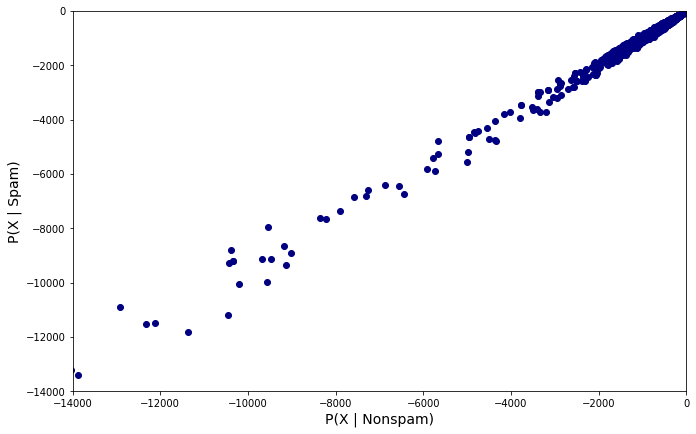

In [71]:
plt.figure(figsize=(11,7))
plt.xlabel(xaxis_label, fontsize=14)
plt.ylabel(yaxis_label, fontsize=14)

# Set scale
plt.xlim([-14000,1])
plt.ylim([-14000,1])

plt.scatter(joint_log_ham,joint_log_spam,color='navy')
plt.show()


## 11.1 The Decision Boundary

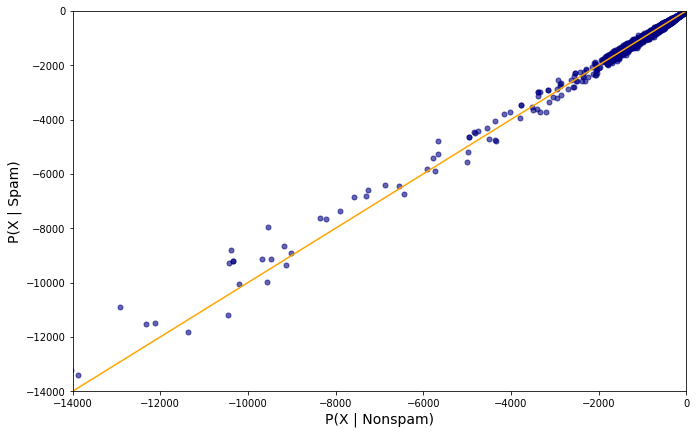

In [72]:
plt.figure(figsize=(11,7))
plt.xlabel(xaxis_label, fontsize=14)
plt.ylabel(yaxis_label, fontsize=14)

# Set scale
plt.xlim([-14000,1])
plt.ylim([-14000,1])

plt.scatter(joint_log_ham,joint_log_spam,color='navy',alpha=0.6,s=25)
plt.plot(linedata,linedata,color='orange')
plt.show()

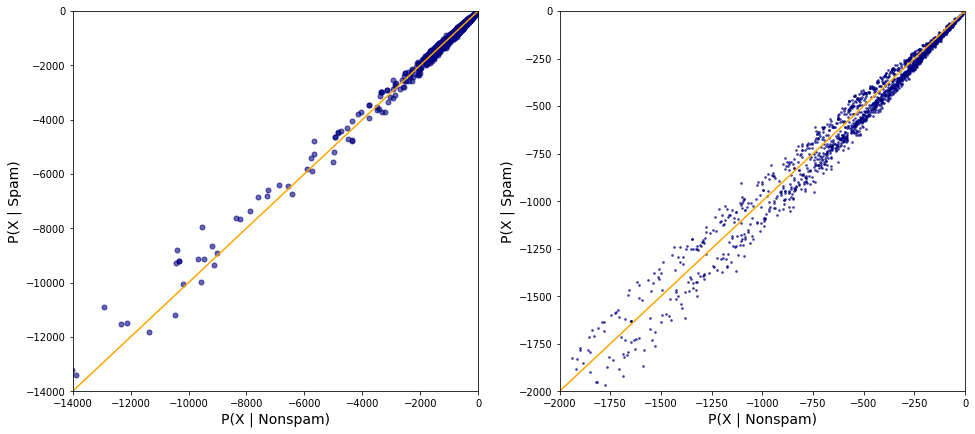

In [73]:
plt.figure(figsize=(16,7))

# Chart #1
plt.subplot(1,2,1)

plt.xlabel(xaxis_label, fontsize=14)
plt.ylabel(yaxis_label, fontsize=14)

# Set scale
plt.xlim([-14000,1])
plt.ylim([-14000,1])

plt.scatter(joint_log_ham,joint_log_spam,color='navy',alpha=0.6,s=25)
plt.plot(linedata,linedata,color='orange')


# Chart #2
plt.subplot(1,2,2)

plt.xlabel(xaxis_label, fontsize=14)
plt.ylabel(yaxis_label, fontsize=14)

# Set scale
plt.xlim([-2000,1])
plt.ylim([-2000,1])

plt.scatter(joint_log_ham,joint_log_spam,color='navy',alpha=0.6,s=3)
plt.plot(linedata,linedata,color='orange')

plt.show()

## 11.2 Charts with Seaborn

In [74]:
# Chart Styling
sns.set_style('whitegrid')
labels = 'Actual Category'

summary_df = pd.DataFrame({yaxis_label: joint_log_spam, xaxis_label: joint_log_ham,
                          labels: y_test})

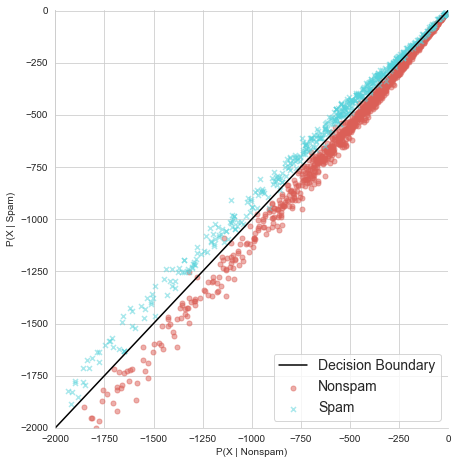

In [75]:
sns.lmplot(x=xaxis_label,y=yaxis_label,data=summary_df, height=6.5, fit_reg=False, legend=False,
          scatter_kws={'alpha':0.5,'s':25}, hue=labels, markers=['o','x'], palette='hls')
# Palette option - hls,Set2, Paired



plt.xlim([-2000,1])
plt.ylim([-2000,1])
plt.plot(linedata,linedata,color='black')
plt.legend(('Decision Boundary','Nonspam','Spam'), loc='lower right', fontsize=14)
plt.show()

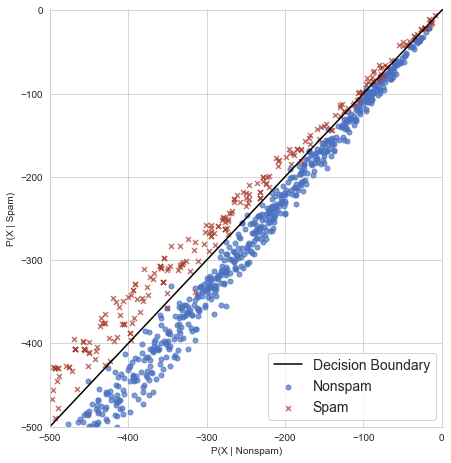

In [76]:
my_colors = ['#4A71C0','#AB3A2C']

sns.lmplot(x=xaxis_label,y=yaxis_label,data=summary_df, height=6.5, fit_reg=False, legend=False,
          scatter_kws={'alpha':0.7,'s':25}, hue=labels, markers=['o','x'], palette=my_colors)
# Palette option - hls,Set2, Paired



plt.xlim([-500,1])
plt.ylim([-500,1])
plt.plot(linedata,linedata,color='black')
plt.legend(('Decision Boundary','Nonspam','Spam'), loc='lower right', fontsize=14)
plt.show()

# 12. Naive Bayes Classifier using Scikit Learn

In [77]:
data = pd.read_json(DATA_JSON_FILE)

In [78]:
vectorizer = CountVectorizer(stop_words='english')
all_features = vectorizer.fit_transform(data.MESSAGE)
vectorizer.vocabulary_

{'doctype': 34865,
 'html': 48472,
 'public': 74013,
 'w3c': 93790,
 'dtd': 36354,
 'transitional': 88580,
 'en': 38432,
 'head': 47011,
 'meta': 61701,
 'content': 30249,
 '3d': 6385,
 'text': 86991,
 'charset': 27796,
 '3dwindows': 7297,
 '1252': 2025,
 'http': 48497,
 'equiv': 38991,
 '3dcontent': 6908,
 'ype': 99054,
 'mshtml': 63412,
 '00': 0,
 '2314': 4235,
 '1000': 1497,
 '3dgenerator': 6987,
 'body': 24390,
 'inserted': 52119,
 'calypso': 26557,
 'table': 86120,
 'border': 24581,
 '3d0': 6386,
 'cellpadding': 27375,
 'cellspacing': 27383,
 '3d2': 6525,
 'id': 49828,
 '3d_calyprintheader_': 6758,
 'ules': 90247,
 '3dnone': 7130,
 'style': 84723,
 'color': 29367,
 'black': 23893,
 'display': 34406,
 'width': 95488,
 '100': 1496,
 'tbody': 86462,
 'tr': 88442,
 'td': 86548,
 'colspan': 29390,
 '3d3': 6570,
 'hr': 48373,
 '3dblack': 6863,
 'noshade': 65849,
 'size': 82347,
 '3d1': 6417,
 'end': 38496,
 'font': 42257,
 '000000': 4,
 'face': 40498,
 '3dverdana': 7283,
 'arial': 20116

In [79]:
X_train, X_test, y_train, y_test = train_test_split(all_features,data.CATEGORY,
                                                    test_size=0.3,random_state=88)

In [80]:
classifier = MultinomialNB()
classifier.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [81]:
nr_correct = (y_test == classifier.predict(X_test)).sum()
print(f'Number of emails classified correctly: {nr_correct}')
nr_incorrect = (y_test != classifier.predict(X_test)).sum()
print(f'Number of emails classified incorrectly: {nr_incorrect}')
fraction_wrong = nr_incorrect / (nr_correct + nr_incorrect)
print(f'The (Testing) Accuracy of the model: {1-fraction_wrong:.2%}')

Number of emails classified correctly: 1641
Number of emails classified incorrectly: 98
The (Testing) Accuracy of the model: 94.36%


In [91]:
from sklearn.metrics import recall_score, precision_score, f1_score
print(f'Accuracy of the Multinomial model is {classifier.score(X_test,y_test):.2%}')
print(f'Recall score of the Multinomial model is {recall_score(y_test,classifier.predict(X_test)):.2%}')
print(f'Precision score of the Multinomial model is {precision_score(y_test,classifier.predict(X_test)):.2%}')
print(f'F1 score of the Multinomial model is {f1_score(y_test,classifier.predict(X_test)):.2%}')

Accuracy of the Multinomial model is 94.36%
Recall score of the Multinomial model is 83.03%
Precision score of the Multinomial model is 99.14%
F1 score of the Multinomial model is 90.37%
